In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
from data_loading import load_evaluated_trials, load_clinical_trials, load_split_queries
import os
import pickle

evaluated_trial_ids = load_evaluated_trials("data/qrels-clinical_trials.txt")
if not os.path.exists("bin/clinical_trials.obj"):
    clinical_trials = load_clinical_trials(
        "data/clinicaltrials.gov-16_dec_2015.tgz", evaluated_trial_ids
    )
    pickle.dump(clinical_trials, open("bin/clinical_trials.obj", "wb"))
else:
    clinical_trials = pickle.load(open("bin/clinical_trials.obj", "rb"))

if not os.path.exists("bin/training_set.obj") or not os.path.exists("bin/test_set.obj"):
    train_queries, test_queries = load_split_queries(
        "data/topics-2014_2015-summary.topics", "data/qrels-clinical_trials.txt"
    )

    pickle.dump(train_queries, open("bin/training_set.obj", "wb"))
    pickle.dump(test_queries, open("bin/test_set.obj", "wb"))
else:
    train_queries = pickle.load(open("bin/training_set.obj", "rb"))
    test_queries = pickle.load(open("bin/test_set.obj", "rb"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgajek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mgajek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mgajek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mgajek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
all_fields_to_use = ["brief_title", "brief_summary", "detailed_description", "criteria"]

In [4]:
print(clinical_trials[0])

ID: NCT00000369
Brief title: mainten therapi bipolar disord
Brief summary: the purpos studi see ad regimen individu psychotherapi help bipolar i patient lithium while manic depress episod patient assign randomli like toss coin receiv appropri medic either without addit individu psychotherapi if patient respond well assign randomli receiv prevent treatment medic manag either continu medic clinic visit alon addit individu psychotherapi patient may receiv addit treatment time patient respons treatment evalu throughout studi if symptom return point studi patient treat appropri medic continu studi an individu may elig studi ha bipolar i disord experienc manic depress episod time studi entri least year old
Detailed description: the primari goal investig examin addit prophylact potenti individu psychotherapi base interperson social rhythm principl bipolar i patient maintain lithium carbon lithium an adapt mainten interperson psychotherapi intervent take account specif vulner symptom interpers

## VSM

In [5]:
from models import VectorSpaceModelTfidfVectorizer, TrailScoreValidator
from itertools import chain, combinations
import numpy as np
import pandas as pd

validator = TrailScoreValidator("data/qrels-clinical_trials.txt")

param_grid = {
    "ngram_range_word": [(1, 1), (1, 2), (2, 2), (3, 3), (1, 3), (2, 3)],
    "ngram_range_char": [(4, 4), (4, 5), (3, 5), (5, 5), (4, 6), (5, 6), (6, 6)],
    "analyzer": ["word", "char", "char_wb"],
    "stop_words": [None],
}


# all_fields_to_use = list(chain.from_iterable(combinations(fields_available, r) for r in range(1, len(fields_available)+1)))

param_grid["fields_to_use"] = ["detailed_description"]

if not os.path.exists("bin/vsm_validation_results.obj"):
    vsm_results = pd.DataFrame()
    for analyzer in param_grid["analyzer"]:
        for ngram_range in param_grid["ngram_range_" + analyzer.replace("_wb", "")]:
            for stop_words in param_grid["stop_words"]:
                model = VectorSpaceModelTfidfVectorizer(
                    ngram_range=ngram_range, analyzer=analyzer, stop_words=stop_words
                )
                model.fit(clinical_trials, param_grid["fields_to_use"])

                ap_list = list()
                for query in train_queries:
                    result = model.get_scores(query)
                    metrics = validator.eval(result, query.id)
                    ap_list.append(metrics["ap"])

                map = np.mean(ap_list)
                s = pd.Series(
                    [
                        analyzer,
                        stop_words,
                        ngram_range,
                        map,
                        param_grid["fields_to_use"],
                    ]
                )
                vsm_results = vsm_results.append(s, ignore_index=True)

    vsm_results.columns = ["analyzer", "stop_words", "ngram_range", "map", "fields"]
    vsm_results = vsm_results.sort_values(by="map", ascending=False)

    pickle.dump(vsm_results, open("bin/vsm_validation_results.obj", "wb"))
else:
    vsm_results = pickle.load(open("bin/vsm_validation_results.obj", "rb"))

vsm_results.head(10)

,analyzer,stop_words,ngram_range,map,fields
14,char_wb,None,"(4, 5)",0.079030,[detailed_description]
13,char_wb,None,"(4, 4)",0.077549,[detailed_description]
16,char_wb,None,"(5, 5)",0.076528,[detailed_description]
7,char,None,"(4, 5)",0.074811,[detailed_description]
15,char_wb,None,"(3, 5)",0.074705,[detailed_description]
17,char_wb,None,"(4, 6)",0.073504,[detailed_description]
18,char_wb,None,"(5, 6)",0.072979,[detailed_description]
6,char,None,"(4, 4)",0.072870,[detailed_description]
9,char,None,"(5, 5)",0.070335,[detailed_description]
19,char_wb,None,"(6, 6)",0.070237,[detailed_description]


In [6]:
analyzer = vsm_results["analyzer"].iloc[0]
stop_words = vsm_results["stop_words"].iloc[0]
ngram_range = vsm_results["ngram_range"].iloc[0]
fields = vsm_results["fields"].iloc[0]
final_vsm_model = VectorSpaceModelTfidfVectorizer(ngram_range, analyzer, stop_words)
final_vsm_model.fit(clinical_trials, fields)

results = pd.DataFrame(
    columns=[
        "p10",
        "recall",
        "ap",
        "ndcg5",
        "mrr",
        "precision_11point",
        "recall_11point",
        "total_relv_ret",
    ]
)

for test_query in test_queries:
    scores = final_vsm_model.get_scores(test_query)
    df_per_case = validator.eval(scores, test_query.id)
    results = pd.concat([results, df_per_case])

print(f"P@10 {np.mean(results['p10'])}")
results

P@10 0.14666666666666664


,p10,recall,ap,ndcg5,mrr,precision_11point,recall_11point,total_relv_ret
201522,0.2,1.0,0.127925,0.315648,0.003861,"[1.0, 0.7999999999999999, 0.15106382978723393,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",14
201527,0.0,1.0,0.006424,0.000000,0.002482,"[0.03225806451612903, 0.03225806451612903, 0.0...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",9
201411,0.0,1.0,0.001969,0.000000,0.002206,"[0.0016556291390728477, 0.0016556291390728477,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",8
201418,0.2,1.0,0.104845,0.218370,0.004137,"[1.0, 0.6666666666666665, 0.04411764705882353,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",15
201412,0.1,1.0,0.015748,0.000000,0.002758,"[0.125, 0.125, 0.00546448087431694, 0.00389105...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",10
201421,0.2,1.0,0.032750,0.000000,0.018753,"[0.14285714285714285, 0.05263157894736842, 0.0...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",68
201524,0.1,1.0,0.046054,0.339160,0.006895,"[1.0, 0.007960631060935013, 0.0072358900144717...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",25
201516,0.3,1.0,0.190866,0.485229,0.003861,"[1.0, 0.7999999999999999, 0.44285714285714284,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",14
201413,0.2,1.0,0.161710,0.517962,0.004688,"[1.0, 1.0, 0.1318181818181818, 0.1050707547169...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",17
20153,0.0,1.0,0.011781,0.000000,0.010204,"[0.011627906976744186, 0.013114981418825226, 0...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",37


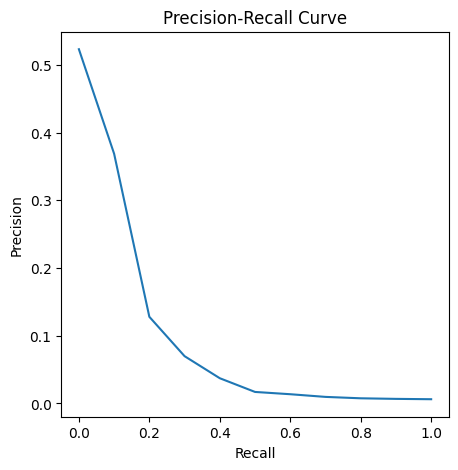

In [7]:
import matplotlib.pyplot as plt


avg_precision_11point = np.array(results["precision_11point"].values.tolist()).mean(
    axis=0
)
avg_recall_11point = np.array(results["recall_11point"].values.tolist()).mean(axis=0)

f, ax = plt.subplots(figsize=(5, 5))
ax.plot(avg_recall_11point, avg_precision_11point)
# _ = ax.set_ylim(bottom=0, top=1)
_ = ax.set_xlabel("Recall")
_ = ax.set_ylabel("Precision")
_ = ax.set_title("Precision-Recall Curve")

In [8]:
from models import LanguageModel
from trec import TrecEvaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import Query
from typing import List


def find_best_lambda_for_lm(
    queries: List[Query],
    lm: LanguageModel,
    lambdas: np.ndarray,
    trec_eval: TrecEvaluation,
):
    trec_eval = TrecEvaluation("data/qrels-clinical_trials.txt")
    p10_per_lambda, recall_per_lambda = list(), list()
    for lambda_ in lambdas:
        p10_per_case, recall_per_case = list(), list()
        for query in queries:
            results: pd.DataFrame = lm.get_results(query.content, lambda_)
            [p10, recall, ap, ndcg5, mrr] = trec_eval.eval(results, query.id)
            p10_per_case.append(p10)
            recall_per_case.append(recall)
        p10_per_lambda.append(np.mean(p10_per_case))
        recall_per_lambda.append(np.mean(recall_per_case))
    best_lambda = lambdas[np.argmax(p10_per_lambda)]
    print(
        f"Best lambda is {best_lambda}, judged by P@10 which was {max(p10_per_lambda):.4f}."
    )
    plt.scatter(lambdas, p10_per_lambda, label="Average P@10", marker=".")
    plt.scatter(lambdas, recall_per_lambda, label="Average recall", marker=".")
    plt.axvline(best_lambda, color="black", linewidth=0.5)
    plt.axhline(max(p10_per_lambda), color="black", linewidth=0.5)
    plt.title(
        f"Precision and recall\nBest lambda = {best_lambda}, judged by P@10 ({max(p10_per_lambda):.4f})"
    )
    plt.xlabel("Lambda")
    plt.legend()
    plt.show()
    return best_lambda

In [9]:
from models import LanguageModel
from trec import TrecEvaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


def evaluate_lm_find_lambda():
    lm_fields_concatenated = LanguageModel(clinical_trials, all_fields_to_use)
    lambdas: np.ndarray[float] = np.linspace(0, 1, num=11)
    trec_eval = TrecEvaluation("data/qrels-clinical_trials.txt")
    best_lambda = find_best_lambda_for_lm(
        train_queries, lm_fields_concatenated, lambdas, trec_eval
    )
    (
        p10_per_case,
        recall_per_case,
        ap_per_case,
        ndcg5_per_case,
        mrr_per_case,
        precision_11point_per_case,
    ) = (
        list(),
        list(),
        list(),
        list(),
        list(),
        list(),
    )
    for query in test_queries:
        results: pd.DataFrame = lm_fields_concatenated.get_results(
            query.content, best_lambda
        )
        p10, recall, ap, ndcg5, mrr = trec_eval.eval(results, query.id)
        precision_11point, recall_11point, total_relv_ret = trec_eval.evalPR(
            results, query.id
        )
        p10_per_case.append(p10)
        recall_per_case.append(recall)
        ap_per_case.append(ap)
        ndcg5_per_case.append(ndcg5)
        mrr_per_case.append(mrr)
        precision_11point_per_case.append(precision_11point)
    lm_eval_metrics = pd.DataFrame(
        {
            "lambda": best_lambda,
            "P@10": np.mean(p10_per_case),
            "Recall": np.mean(recall_per_case),
            "MAP": np.mean(ap_per_case),
            "NDCG@5": np.mean(ndcg5_per_case),
            "MRR": np.mean(mrr_per_case),
        },
        index=[0],
    )
    precision_11point = np.mean(precision_11point_per_case, axis=0)
    plt.plot(recall_11point, precision_11point)
    plt.title("Precision/Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    return lm_eval_metrics


if not os.path.exists("bin/lm_validation_results.obj"):
    lm_eval_metrics = evaluate_lm_find_lambda()
    pickle.dump(lm_eval_metrics, open("bin/lm_validation_results.obj", "wb"))
else:
    lm_eval_metrics = pickle.load(open("bin/lm_validation_results.obj", "rb"))
best_lambda = lm_eval_metrics.loc[0, "lambda"]
lm_eval_metrics

,lambda,P@10,Recall,MAP,NDCG@5,MRR
0,0.1,0.126667,1.0,0.06287,0.153036,0.005865


In [10]:
print(lm_eval_metrics.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  lambda &      P@10 &  Recall &      MAP &    NDCG@5 &       MRR \\
\midrule
0 &     0.1 &  0.126667 &     1.0 &  0.06287 &  0.153036 &  0.005865 \\
\bottomrule
\end{tabular}



In [11]:
from typing import List
from data import Query
from models import TrailScoreValidator

def evaluate_models(queries: List[Query], fields_to_use: List[str], lambda_: float):
    tsv = TrailScoreValidator("data/qrels-clinical_trials.txt")
    for field in fields_to_use:
        lm = LanguageModel(clinical_trials, field)
        score = pd.DataFrame()
        for query in queries:
            results = lm.get_results(query.content, lambda_)
            scores = tsv.eval(results, query.id)
            score = pd.concat([score, scores])
        evaluation = score.mean(axis = 0)
        print(field)
        print(evaluation.to_latex())

evaluate_models(test_queries, all_fields_to_use, best_lambda)

brief_title
\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
p10            &   0.046667 \\
recall         &   1.000000 \\
ap             &   0.024043 \\
ndcg5          &   0.054590 \\
mrr            &   0.005865 \\
total\_relv\_ret &  21.266667 \\
\bottomrule
\end{tabular}

brief_summary
\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
p10            &   0.046667 \\
recall         &   1.000000 \\
ap             &   0.024043 \\
ndcg5          &   0.054590 \\
mrr            &   0.005865 \\
total\_relv\_ret &  21.266667 \\
\bottomrule
\end{tabular}

detailed_description
\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
p10            &   0.046667 \\
recall         &   1.000000 \\
ap             &   0.024043 \\
ndcg5          &   0.054590 \\
mrr            &   0.005865 \\
total\_relv\_ret &  21.266667 \\
\bottomrule
\end{tabular}

criteria
\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
p10            &   0.046667 \\
recall         &   1.000000 \\
ap       

## Get all query-document pairs with cases excluded based on gender, max and min age

In [12]:
import re
from data import Gender, Query, ClinicalTrial
from data_loading import get_all_documents_relevance
from preprocessing import lemmatize

np.seterr(all="raise")


def get_all_relevances():
    return get_all_documents_relevance("data/qrels-clinical_trials.txt")


def get_age(query: Query):
    content = query.content.lower()
    result_n = None
    result = re.search("(?P<n>\d+)[- ]year[- ]old", content)
    if not result:
        result = re.search("(?P<n>\d+) ?yo", content)
    if not result:
        result = re.search("(?P<n>\d+)[- ]month[- ]old", content)
        if result:
            result_n = float(result.group("n")) / 12
    else:
        result_n = result.group("n")
    return result_n


def get_gender(query: Query):
    content = query.content.lower().replace("human", "")
    result_men = re.search("\s(m[ae]n|males?|boys?)[\s\,.!?]", content)
    result_women = re.search("wom[ae]n|females?|girls?|in menopause", content)
    return (
        Gender.Male
        if result_men and not result_women
        else Gender.Female
        if result_women and not result_men
        else Gender.Both
    )


def trial_not_empty(trial: ClinicalTrial):
    return trial.brief_title or trial.brief_summary or trial.detailed_description


def is_trial_possible_for_query(query: Query, trial: ClinicalTrial):
    query_age = get_age(query)
    query_gender = get_gender(query)
    return (
        (
            query_age is None
            or (trial.max_age is None or float(trial.max_age) > float(query_age))
            and (trial.min_age is None or float(trial.min_age) < float(query_age))
        )
        and (
            trial.gender == Gender.Both
            or query_gender == trial.gender
            or query_gender is None
        )
        and trial_not_empty(trial)
    )


def calculate_query_trial_results(queries):
    models_with_fields_labels = [
        f"{model_name}({fields})"
        for model_name in ["VSM", "LMJM"]
        for fields in all_fields_to_use
    ]
    query_trial_results = pd.DataFrame(
        columns=["query_id", "trial_id", "true_relevance"] + models_with_fields_labels
    )
    for query in queries:
        for_query_results = pd.DataFrame(
            columns=["query_id", "trial_id", "true_relevance"]
        )
        applicable_trials = [
            trial
            for trial in clinical_trials
            if is_trial_possible_for_query(query, trial)
        ]
        for id, field in enumerate(all_fields_to_use):
            # VSM
            final_vsm_model.fit(applicable_trials, [field])
            trial_scores = final_vsm_model.get_scores(query)
            trial_scores = trial_scores.assign(query_id=query.id)
            if id == 0:
                for_query_results["query_id"] = trial_scores["query_id"]
                for_query_results["trial_id"] = trial_scores["_id"]
            for_query_results[f"VSM({field})"] = trial_scores["score"]

            # LMJM
            lm = LanguageModel(applicable_trials, [field])
            trial_scores = lm.get_results(query.content, best_lambda)
            for_query_results[f"LMJM({field})"] = trial_scores["score"]

        query_trial_results = pd.concat([query_trial_results, for_query_results])

    trials_relevance = get_all_relevances()

    query_trial_results["true_relevance"] = query_trial_results["trial_id"].map(
        trials_relevance
    )

    return query_trial_results


if not os.path.exists("bin/query_trial_results.obj"):
    query_trial_results = calculate_query_trial_results(train_queries)
    pickle.dump(query_trial_results, open("bin/query_trial_results.obj", "wb"))
else:
    query_trial_results = pickle.load(open("bin/query_trial_results.obj", "rb"))

print(query_trial_results.head(5).to_latex())

query_trial_results

\begin{tabular}{llllrrrrrrrr}
\toprule
{} & query\_id &     trial\_id & true\_relevance &  VSM(brief\_title) &  VSM(brief\_summary) &  VSM(detailed\_description) &  VSM(criteria) &  LMJM(brief\_title) &  LMJM(brief\_summary) &  LMJM(detailed\_description) &  LMJM(criteria) \\
\midrule
2336 &   201530 &  NCT02463630 &              0 &          0.181707 &            0.156234 &                   0.189304 &       0.076884 &         -84.728779 &          -113.871199 &                 -127.675318 &     -114.921353 \\
956  &   201530 &  NCT00957021 &              0 &          0.152396 &            0.089123 &                   0.053720 &       0.096116 &         -90.881512 &          -119.330675 &                 -133.969372 &     -116.959871 \\
228  &   201530 &  NCT00163709 &              1 &          0.137627 &            0.042763 &                   0.065456 &       0.059335 &         -86.841389 &          -122.650386 &                 -131.036370 &     -116.155220 \\
611  &   201530 &  NC

,query_id,trial_id,true_relevance,VSM(brief_title),VSM(brief_summary),VSM(detailed_description),VSM(criteria),LMJM(brief_title),LMJM(brief_summary),LMJM(detailed_description),LMJM(criteria)
2336,201530,NCT02463630,0,0.181707,0.156234,0.189304,0.076884,-84.728779,-113.871199,-127.675318,-114.921353
956,201530,NCT00957021,0,0.152396,0.089123,0.053720,0.096116,-90.881512,-119.330675,-133.969372,-116.959871
228,201530,NCT00163709,1,0.137627,0.042763,0.065456,0.059335,-86.841389,-122.650386,-131.036370,-116.155220
611,201530,NCT00586365,0,0.120614,0.084601,0.000000,0.056456,-86.157078,-120.038859,-135.334341,-114.177632
2479,201530,NCT02596659,0,0.115126,0.097558,0.000000,0.313943,-86.157078,-119.608882,-135.334341,-108.423492
...,...,...,...,...,...,...,...,...,...,...,...
620,201515,NCT00664339,1,0.000000,0.023042,0.025399,0.039576,-82.948253,-136.506569,-137.489237,-132.351662
1647,201515,NCT01877707,0,0.000000,0.000749,0.005287,0.004897,-82.948253,-136.506569,-137.489237,-132.124820
1648,201515,NCT01885533,1,0.000000,0.004540,0.000000,0.006718,-82.948253,-136.506569,-137.489237,-132.351662
1649,201515,NCT01887028,0,0.000000,0.003070,0.026913,0.007119,-82.948253,-136.506569,-135.883649,-132.003352


In [13]:
import re


def run_if_restarted_kernel():
    """
    VSM model returns a dataframe containing lists of 1 element isntead of one element, which might break some funcions (like np.histogram).
    Until a fix is in place this has to be run every time kernel is restarted.
    """
    print(query_trial_results.columns)
    for column in query_trial_results.columns:
        if re.match("vsm", column.lower()):
            query_trial_results[column] = query_trial_results[column].apply(
                lambda cell: cell[0]
            )
    pickle.dump(query_trial_results, open("bin/query_trial_results.obj", "wb"))


# run_if_restarted_kernel()

## Training logistic regression to label query-trial pairs as relevant/not relevant

In [15]:
import re
import pandas as pdd
import matplotlib.pyplot as plt


def plot_variable_distributions(results: pd.DataFrame):
    vsm_columns, lm_columns = list(), list()
    for column in results.columns:
        if re.match("vsm", column.lower()):
            vsm_columns.append(column)
        elif re.match("lmjm", column.lower()):
            lm_columns.append(column)
    _, vsm_subplots = plt.subplots(1, len(vsm_columns))
    for i, column in enumerate(vsm_columns):
        vsm_subplots[i].hist(results[column], bins=60)
        vsm_subplots[i].set_title(column)
        print(
            f"Max value for {column} is {max(results[column])}",
            f"Min value for {column} is {min(results[column])}",
            sep="\n",
        )
    plt.suptitle("VSM score distribution")
    plt.setp(vsm_subplots, xlabel="Values", ylabel="Number of occurances")
    plt.tight_layout()
    plt.savefig("figures/VSM_distributions.png")
    _, lm_subplots = plt.subplots(1, 3)
    for i, column in enumerate(lm_columns):
        lm_subplots[i].hist(results[column], bins=30)
        lm_subplots[i].set_title(column)
        print(
            f"Max value for {column} is {max(results[column])}",
            f"Min value for {column} is {min(results[column])}",
            sep="\n",
        )
    plt.suptitle("LMJM score distribution")
    plt.setp(lm_subplots, xlabel="Values", ylabel="Number of occurances")
    plt.tight_layout()
    plt.savefig("figures/LM_distributions.png")
    plt.plot()


#plot_variable_distributions(query_trial_results)

IndexError: index 3 is out of bounds for axis 0 with size 3

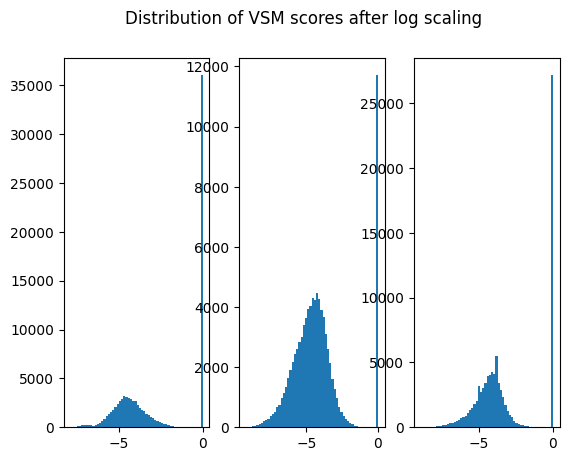

In [16]:
from normalization import Normalizer
import pandas as pd


def normalize_results_tests(original_results: pd.DataFrame) -> pd.DataFrame:

    results = original_results.copy()
    np.seterr("warn")
    vsm_columns, lm_columns = list(), list()
    for column in results.columns:
        if re.match("vsm", column.lower()):
            vsm_columns.append(column)
        elif re.match("lmjm", column.lower()):
            lm_columns.append(column)

    _, vsm_test_subplots = plt.subplots(1, 3)
    plt.suptitle("Distribution of VSM scores after log scaling")
    for i, column in enumerate(vsm_columns):
        test_results = np.log(results[column].mask(results[column] <= 0)).fillna(0)
        vsm_test_subplots[i].hist(test_results, bins=60)
    plt.setp(vsm_test_subplots, xlabel="Values", ylabel="Number of occurances")
    plt.tight_layout()
    plt.savefig("figures/log_scaled_VSM.png")

    normalizer_vsm = Normalizer().fit_linear_scale(results[vsm_columns].to_numpy())
    normalizer_lm = Normalizer().fit_linear_scale(results[lm_columns].to_numpy())

    _, vsm_subplots = plt.subplots(1, len(vsm_columns))
    for i, column in enumerate(vsm_columns):
        results[column] = normalizer_vsm.transform_linear_scale(results[column])
        vsm_subplots[i].hist(results[column], bins=60)
    plt.setp(vsm_subplots, xlim=(0, 1))
    _, lm_subplots = plt.subplots(1, 3)
    for i, column in enumerate(lm_columns):
        results[column] = normalizer_lm.transform_linear_scale(results[column])
        lm_subplots[i].hist(results[column], bins=30)
    plt.setp(lm_subplots, xlim=(0, 1))
    plt.plot()

    return results, normalizer_vsm, normalizer_lm


normalized_results, normalizer_vsm, normalizer_lm = normalize_results_tests(
    query_trial_results
)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from typing import List


def normalize_data(original_results: pd.DataFrame, fields_to_use: List[str]):
    results = original_results.copy()
    scaler = StandardScaler()
    vsm_columns = [f"VSM({field})" for field in fields_to_use]
    lm_columns = [f"LMJM({field})" for field in fields_to_use]
    results[vsm_columns + lm_columns] = scaler.fit_transform(
        original_results[vsm_columns + lm_columns]
    )
    return results, scaler


# normalized_results, scaler = normalize_data(query_trial_results, all_fields_to_use)
normalized_results["true_relevance"] = normalized_results["true_relevance"].apply(
    lambda x: int(x)
)
normalized_results["relevance"] = [
    0 if true_relevance == 0 else 1
    for true_relevance in normalized_results["true_relevance"]
]


def plot_distributions_after_normalizing(results):
    vsm_columns, lm_columns = list(), list()
    for column in results.columns:
        if re.match("vsm", column.lower()):
            vsm_columns.append(column)
        elif re.match("lmjm", column.lower()):
            lm_columns.append(column)
    _, vsm_subplots = plt.subplots(1, 3)
    for i, column in enumerate(vsm_columns):
        vsm_subplots[i].hist(results[column], bins=60)
    _, lm_subplots = plt.subplots(1, 3)
    for i, column in enumerate(lm_columns):
        lm_subplots[i].hist(results[column], bins=30)
    plt.plot()


#plot_distributions_after_normalizing(normalized_results)

normalized_results

,query_id,trial_id,true_relevance,VSM(brief_title),VSM(brief_summary),VSM(detailed_description),VSM(criteria),LMJM(brief_title),LMJM(brief_summary),LMJM(detailed_description),LMJM(criteria),relevance
2336,201530,NCT02463630,0,7.475145,7.085275,9.303227,2.784671,0.041005,-0.143707,-0.280559,-0.088316,0
956,201530,NCT00957021,0,6.182721,3.746145,2.146410,3.707808,-0.141812,-0.273986,-0.425943,-0.136698,0
228,201530,NCT00163709,1,5.531535,1.439479,2.765921,1.942284,-0.021768,-0.353203,-0.358195,-0.117600,1
611,201530,NCT00586365,0,4.781399,3.521186,-0.689209,1.804063,-0.001435,-0.290885,-0.457472,-0.070665,0
2479,201530,NCT02596659,0,4.539386,4.165838,-0.689209,14.163748,-0.001435,-0.280624,-0.457472,0.065903,0
...,...,...,...,...,...,...,...,...,...,...,...,...
620,201515,NCT00664339,1,-0.536788,0.458287,0.651486,0.993828,0.093909,-0.683852,-0.507248,-0.502005,1
1647,201515,NCT01877707,0,-0.536788,-0.650910,-0.410120,-0.670792,0.093909,-0.683852,-0.507248,-0.496621,0
1648,201515,NCT01885533,1,-0.536788,-0.462308,-0.689209,-0.583394,0.093909,-0.683852,-0.507248,-0.502005,1
1649,201515,NCT01887028,0,-0.536788,-0.535419,0.731378,-0.564157,0.093909,-0.683852,-0.470161,-0.493738,0


In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from typing import List, Iterable, Union
from models import TrailScoreValidator
import numpy as np


def train_logistic_regressions(
    data: pd.DataFrame,
    fields_to_use: List[str],
    inv_regularization_strengths: Iterable[float],
):
    vsm_columns = [f"VSM({field})" for field in fields_to_use]
    lm_columns = [f"LMJM({field})" for field in fields_to_use]
    columns = vsm_columns + lm_columns
    features_training = data[columns].to_numpy()
    labels_training = data["relevance"].to_numpy()
    number_of_relevant = np.sum(labels_training)
    class_importance = {
        0: number_of_relevant / len(labels_training),
        1: (len(labels_training) - number_of_relevant) / len(labels_training),
    }

    regressor_no_correction = LogisticRegressionCV(Cs=inv_regularization_strengths, class_weight=None)
    regressor_balanced = LogisticRegressionCV(Cs=inv_regularization_strengths, class_weight="balanced")
    regressor_class_importance = LogisticRegressionCV(Cs=inv_regularization_strengths, class_weight=class_importance)

    regressor_no_correction.fit(features_training, labels_training)
    regressor_balanced.fit(features_training, labels_training)
    regressor_class_importance.fit(features_training, labels_training)

    return (regressor_no_correction, regressor_balanced, regressor_class_importance)


if not os.path.exists("bin/regressors.obj"):
    c_to_test = [0.1, 0.33, 0.5, 0.7, 0.9, 1, 1.2, 1.5, 1.8, 2, 3, 4]
    regressors = train_logistic_regressions(
        normalized_results, all_fields_to_use, c_to_test
    )
    pickle.dump(regressors, open("bin/regressors.obj", "wb"))
else:
    regressors = pickle.load(open("bin/regressors.obj", "rb"))
(regressor_no_correction, regressor_balanced, regressor_class_importance) = regressors
print(
    f"No correction coefs    {regressor_no_correction.coef_}",
    f"Balanced mode coefs    {regressor_balanced.coef_}",
    f"Class importance coefs {regressor_class_importance.coef_}",
    sep="\n",
)

No correction coefs    [[-0.00935882  0.03524051 -0.03012721 -0.09971266 -0.00710482  0.03911902
  -0.06284833  0.0182092 ]]
Balanced mode coefs    [[-0.00923442  0.03516526 -0.02961407 -0.0927481  -0.00557612  0.03899827
  -0.05918899  0.01446875]]
Class importance coefs [[-0.00950236  0.03529589 -0.03056342 -0.10488227 -0.00845365  0.03895418
  -0.06450208  0.0204062 ]]


In [ ]:
test_query_results = calculate_query_trial_results(test_queries)
vsm_columns = [f"VSM({field})" for field in all_fields_to_use]
lm_columns = [f"LMJM({field})" for field in all_fields_to_use]
columns = vsm_columns + lm_columns
normalized_test_data = test_query_results.copy()
normalized_test_data[vsm_columns] = normalizer_vsm.transform_linear_scale(
    test_query_results[vsm_columns]
)
normalized_test_data[lm_columns] = normalizer_lm.transform_linear_scale(
    test_query_results[lm_columns]
)
normalized_test_data

,query_id,trial_id,true_relevance,VSM(brief_title),VSM(brief_summary),VSM(detailed_description),VSM(criteria),LMJM(brief_title),LMJM(brief_summary),LMJM(detailed_description),LMJM(criteria)
1922,201522,NCT02269761,0,8.182144,4.953490,4.625479,1.894317,-0.462297,-0.760620,-0.517322,-0.720877
1300,201522,NCT01539161,0,7.209546,3.907187,0.030681,-0.022335,-0.451874,-0.772029,-0.648241,-0.800672
1362,201522,NCT01607775,0,5.705188,-0.353084,-0.689209,-0.905862,-0.628335,-0.906413,-0.659255,-0.800672
1048,201522,NCT01213693,1,5.420756,1.340758,-0.689209,0.301172,-0.479515,-0.856563,-0.659255,-0.760891
1733,201522,NCT02056613,0,5.235981,1.892998,0.925557,0.622216,-0.486798,-0.867025,-0.609510,-0.771003
...,...,...,...,...,...,...,...,...,...,...,...
1359,20152,NCT01467973,2,-0.536788,-0.341303,-0.077491,-0.419033,0.503505,0.681666,0.783616,1.190352
1358,20152,NCT01465425,2,-0.536788,-0.541395,-0.459894,-0.819822,0.503505,0.681666,0.783616,1.182535
1355,20152,NCT01460082,2,-0.536788,-0.688188,-0.497842,-0.135424,0.503505,0.681666,0.783616,1.187693
325,20152,NCT00295516,0,-0.536788,-0.452727,-0.131764,-0.284828,0.503505,0.681666,0.783616,1.186907


In [ ]:
def score_regressors(
    fields_to_use: List[str],
    regressors: List[LogisticRegression],
    query_results: pd.DataFrame,
) -> pd.DataFrame:
    tsv = TrailScoreValidator("data/qrels-clinical_trials.txt")
    vsm_columns = [f"VSM({field})" for field in fields_to_use]
    lm_columns = [f"LMJM({field})" for field in fields_to_use]
    columns = vsm_columns + lm_columns
    features = query_results[columns].to_numpy()
    evaluation = pd.DataFrame(
        columns=[
            "p10",
            "recall",
            "ap",
            "ndcg5",
            "mrr",
            "precision_11point",
            "recall_11point",
            "total_relv_ret",
        ]
    )
    evaluations, scores_per_regressor = list(), list()
    for regressor in regressors:
        scores = np.sum(features * regressor.coef_, axis=1)
        results = pd.DataFrame(
            {
                "query_id": query_results["query_id"],
                "_id": query_results["trial_id"],
                "score": scores,
            }
        )
        scores_per_regressor.append(results)

        for query_id in np.unique(query_results["query_id"]):
            results_of_query = results.loc[results["query_id"] == query_id]
            evaluation_per_query = tsv.eval(results_of_query, query_id)
            evaluation = pd.concat([evaluation, evaluation_per_query])
        evaluations.append(evaluation)
    return evaluations, scores_per_regressor


test_results, scores = score_regressors(
    all_fields_to_use,
    [
        regressor_no_correction,
        regressor_balanced,
        regressor_class_importance,
    ],
    normalized_test_data,
)

In [ ]:
scores

[        p10    recall        ap     ndcg5       mrr  \
 201411  0.0  0.875000  0.001954  0.000000  0.002668   
 201412  0.0  0.600000  0.001304  0.000000  0.002291   
 201413  0.1  0.882353  0.064066  0.218370  0.005686   
 201418  0.0  0.600000  0.015005  0.000000  0.024862   
 201419  0.1  1.000000  0.037237  0.196874  0.014642   
 201421  0.0  0.941176  0.019672  0.000000  0.025029   
 20148   0.0  0.846154  0.003573  0.000000  0.004506   
 201516  0.0  0.285714  0.002114  0.000000  0.008282   
 201519  0.0  1.000000  0.010024  0.000000  0.013240   
 20152   0.1  1.000000  0.022006  0.073034  0.006555   
 201522  0.0  1.000000  0.010727  0.000000  0.006244   
 201524  0.1  0.920000  0.046951  0.339160  0.009361   
 201527  0.0  0.444444  0.004195  0.000000  0.006390   
 20153   0.0  0.918919  0.017875  0.000000  0.015165   
 20155   0.0  1.000000  0.001673  0.000000  0.001128   
 
                                         precision_11point  \
 201411  [0.002079002079002079, 0.002079

Final results for no correction:
p10                                                           0.026667
recall                                                        0.820917
ap                                                            0.017225
ndcg5                                                         0.055163
mrr                                                           0.009737
precision_11point    [0.2225055226857297, 0.034778436329869926, 0.0...
recall_11point       [0.0, 0.10000000000000002, 0.20000000000000004...
total_relv_ret                                               18.666667
dtype: object
##############################
Final results for balanced:
p10                                                           0.016667
recall                                                        0.820917
ap                                                            0.012935
ndcg5                                                         0.027581
mrr                                       

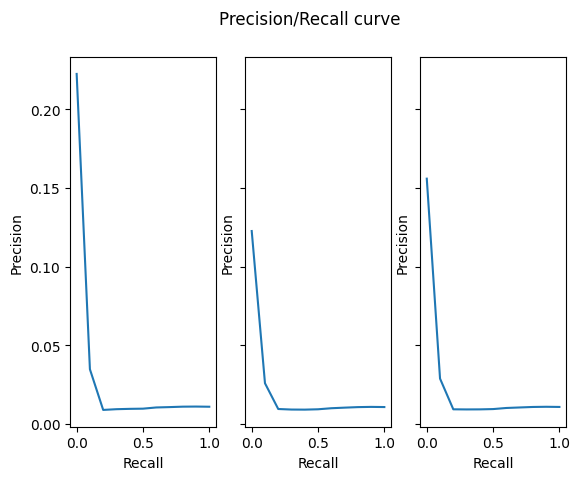

In [ ]:
def get_final_result(test_result: pd.DataFrame, subplot: plt.Axes):
    final_result = test_result.apply(lambda x: x.values.mean(axis=0))
    subplot.plot(final_result["recall_11point"], final_result["precision_11point"])
    return final_result


corrections = ["no correction", "balanced", "class importance"]
_, subplots = plt.subplots(1, 3, sharex=True, sharey=True)
results = pd.DataFrame()
for i, result in enumerate(test_results):
    final_result = get_final_result(result, subplots[i])
    with np.printoptions(threshold=np.inf, linewidth=np.inf):
        print(f"Final results for {corrections[i]}:", final_result, "#" * 30, sep="\n")
    results = pd.concat([results, final_result], axis=1)
plt.suptitle("Precision/Recall curve")
plt.setp(subplots, xlabel="Recall")
plt.setp(subplots, ylabel="Precision")
plt.savefig("figures/precision_recall_final_result.png")
plt.show()

print(results.to_latex())
results

In [ ]:
for score in scores:
    df = pd.DataFrame(columns=["#1", "#2", "#3"])
    for query_id in np.unique(score["query_id"]):
        best_scores_for_query = (
            score.loc[score["query_id"] == query_id]
            .sort_values(by=["score"], ascending=False)
            .head(3)
        )
        top_results = best_scores_for_query["_id"]
        query = next(filter(lambda q: q.id == query_id, test_queries))
        df.loc[query_id] = top_results.to_numpy()
    print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} &           \#1 &           \#2 &           \#3 \\
\midrule
201410 &  NCT01899339 &  NCT01326507 &  NCT00674778 \\
201412 &  NCT01421316 &  NCT01692574 &  NCT00524238 \\
201413 &  NCT01251744 &  NCT01041924 &  NCT01217567 \\
201414 &  NCT01633593 &  NCT00540072 &  NCT00015626 \\
201419 &  NCT01692574 &  NCT01913743 &  NCT01579344 \\
201420 &  NCT00950625 &  NCT01019681 &  NCT02233569 \\
201424 &  NCT00115128 &  NCT01048541 &  NCT02233569 \\
20143  &  NCT01609101 &  NCT01858129 &  NCT01149447 \\
201514 &  NCT02463942 &  NCT01167205 &  NCT01738607 \\
201515 &  NCT01041924 &  NCT02596555 &  NCT02428140 \\
201525 &  NCT00610818 &  NCT01700101 &  NCT01933217 \\
201526 &  NCT01321788 &  NCT02427854 &  NCT02149472 \\
20153  &  NCT01992224 &  NCT01326507 &  NCT02399150 \\
20155  &  NCT01110304 &  NCT00119678 &  NCT01251744 \\
20159  &  NCT01736709 &  NCT02600039 &  NCT00172263 \\
\bottomrule
\end{tabular}

##################################################
\be

,p10,recall,ap,ndcg5,mrr,precision_11point,recall_11point,total_relv_ret
201410,0.1,0.937500,0.024486,0.090743,0.006206,"[0.3333333333333333, 0.13521716378859233, 0.00...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",15
201412,0.0,0.600000,0.002245,0.000000,0.002291,"[0.00847457627118644, 0.00847457627118644, 0.0...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",6
201413,0.0,0.882353,0.003181,0.000000,0.005686,"[0.0020491803278688526, 0.003261256933899408, ...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",15
201414,0.0,0.909091,0.003615,0.000000,0.005679,"[0.0016722408026755853, 0.001742264646488691, ...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",10
201419,0.0,1.000000,0.008885,0.000000,0.014642,"[0.008928571428571428, 0.00452863399073668, 0....","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",37
201420,0.0,0.933333,0.003107,0.000000,0.005843,"[0.0007107320540156361, 0.0009241942408872264,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",14
201424,0.0,0.833333,0.001032,0.000000,0.002035,"[0.0004640371229698376, 0.0004640371229698376,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",5
20143,0.0,0.968750,0.006438,0.000000,0.011765,"[0.0028169014084507044, 0.0033587353124285815,...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",31
201514,0.0,1.000000,0.001007,0.000000,0.001692,"[0.00037425149700598805, 0.0003742514970059880...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",6
201515,0.1,0.961538,0.019144,0.169580,0.010785,"[0.3333333333333333, 0.008204876452299132, 0.0...","[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...",25


##### TODO:
* try other data preprocessing
* try expanding features into polufeatures